# Synthetic Features and Outliers

**Learning Objectives**
* Create a synthetic feature that is the ratio of two other features.
* Use this new feature as the input to a linear regression model.
* Improve the effectiveness of the model by identifying and clipping outliers out of the input data.

We will revisit the model from the Introduction to TensorFlow exercise.

Import the necessary packages to work with this exercise:

In [4]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


Lets import the California housing data into a Pandas dataframe:

In [5]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

Shuffle the order of the dataframe's contents:

In [6]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

Adjust our target column to be in the thousands:

In [7]:
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
6419,-118.3,33.9,36.0,2230.0,417.0,1395.0,381.0,2.8,109.6
14359,-122.1,37.7,29.0,1298.0,306.0,835.0,338.0,2.3,170.4
12995,-121.8,37.3,16.0,2987.0,874.0,4241.0,841.0,2.8,127.9
11891,-121.4,38.7,14.0,756.0,141.0,424.0,155.0,3.7,116.1
10006,-119.8,34.4,28.0,3318.0,441.0,1604.0,404.0,9.8,500.0
...,...,...,...,...,...,...,...,...,...
3223,-117.8,33.7,28.0,1499.0,574.0,3328.0,595.0,2.5,115.0
2343,-117.5,33.9,31.0,2191.0,459.0,1564.0,450.0,2.7,122.0
3230,-117.9,34.1,33.0,2383.0,428.0,1269.0,421.0,4.6,245.5
15375,-122.3,37.6,34.0,1693.0,281.0,846.0,291.0,5.4,339.4


Lets use our input function from the previous exercise:

In [8]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

Our function for model training:

In [9]:
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
      
  Returns:
    A Pandas `DataFrame` containing targets and the corresponding predictions done
    after training the model.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label].astype('float32')

  # Create input functions.
  training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Create a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  
  return calibration_data

# Task 1: Creating a Synthetic Feature

Recall that total_rooms and population features count totals for a given city block.

We can analyze the relationship of block density to median house value by creating a synthetic feature that is the ratio of total rooms and population.

We create a synthetic feature called rooms_per_person, and use that as the new input feature to train_model().

We seek to find the best performance we can get with this single feature and tweaking the learning rate.
A better performance means a better regression line to fit the data and a lower Root Mean Squared Error.

In [10]:
california_housing_dataframe["rooms_per_person"] = california_housing_dataframe["total_rooms"]/california_housing_dataframe["population"]

In [12]:
california_housing_dataframe["rooms_per_person"] 

6419    1.6
14359   1.6
12995   0.7
11891   1.8
10006   2.1
         ..
3223    0.5
2343    1.4
3230    1.9
15375   2.0
9044    1.3
Name: rooms_per_person, Length: 17000, dtype: float64

Training model...
RMSE (on training data):
  period 00 : 213.57
  period 01 : 190.41
  period 02 : 169.61
  period 03 : 152.70
  period 04 : 140.40
  period 05 : 135.05
  period 06 : 131.52
  period 07 : 130.76
  period 08 : 131.34
  period 09 : 131.77
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,196.8,207.3
std,90.2,116.0
min,45.4,15.0
25%,161.4,119.4
50%,193.8,180.4
75%,221.3,265.0
max,4303.4,500.0


Final RMSE (on training data): 131.77


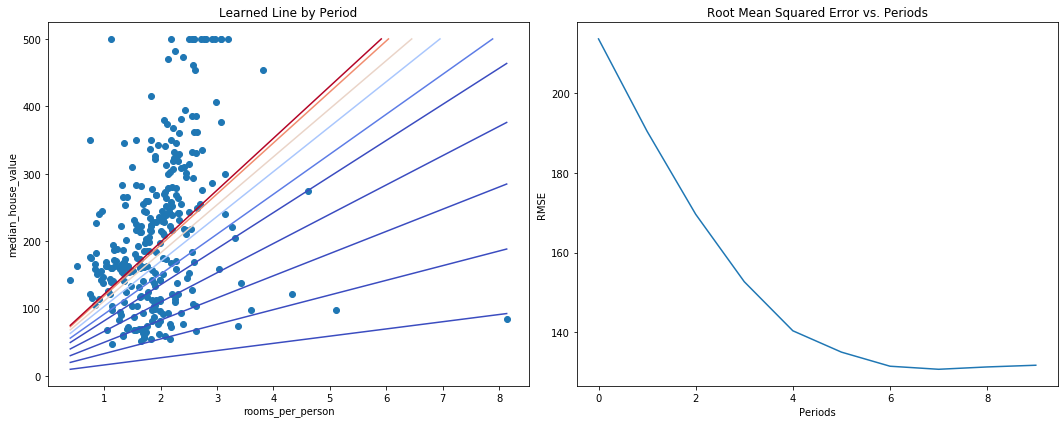

In [14]:
calibration_data = train_model(
    learning_rate = 0.05,
    steps = 500,
    batch_size = 5,
    input_feature = "rooms_per_person"
)

# Task 2: Identifying Outliers

It is helpful to visualize the performance of our model by creating a scatter plot of predictions vs target values. 
Ideally, these would lie on a perfectly correlated diagonal line.

We can use Pyplot's scatter() function to create a scatter plot of predictions vs. targets using the rooms-per-person model trained in Task 1.

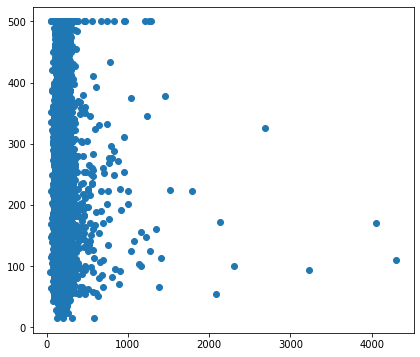

In [15]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(calibration_data["predictions"],calibration_data["targets"])

Notice that most of our correlation data lies on a vertical line, however there are several points which deviate heavily from the line. These are few in number. Let's take a look at a histogram of rooms_per_person, here we will be able to see a few outliers in the input data.

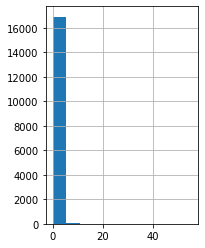

In [16]:
plt.subplot(1,2,2)
_ = california_housing_dataframe["rooms_per_person"].hist()

# Task 3: Clip Outliers

We are interested in seeing if we can improve the model fit by setting the outlier values of rooms_per_person to a reasonable minimum or maximum.
The histogram we just created shows that the majority of values are less than 5.
We may clip rooms_per_person to 5 and re plot the histogram to check the results.

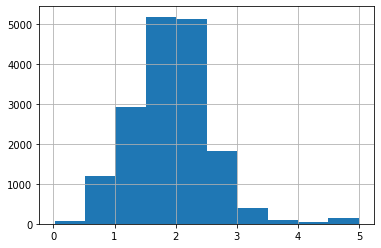

In [28]:
california_housing_dataframe["rooms_per_person"] = (california_housing_dataframe['rooms_per_person']).apply(lambda x: min(x,5))

_ = california_housing_dataframe["rooms_per_person"].hist()

Now that we have clipped our data, let's train our model again and print the calibration data once more:

Training model...
RMSE (on training data):
  period 00 : 212.80
  period 01 : 189.06
  period 02 : 166.80
  period 03 : 146.75
  period 04 : 130.55
  period 05 : 120.69
  period 06 : 115.03
  period 07 : 111.76
  period 08 : 109.74
  period 09 : 108.42
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,193.5,207.3
std,50.4,116.0
min,45.6,15.0
25%,161.3,119.4
50%,193.5,180.4
75%,221.0,265.0
max,428.8,500.0


Final RMSE (on training data): 108.42


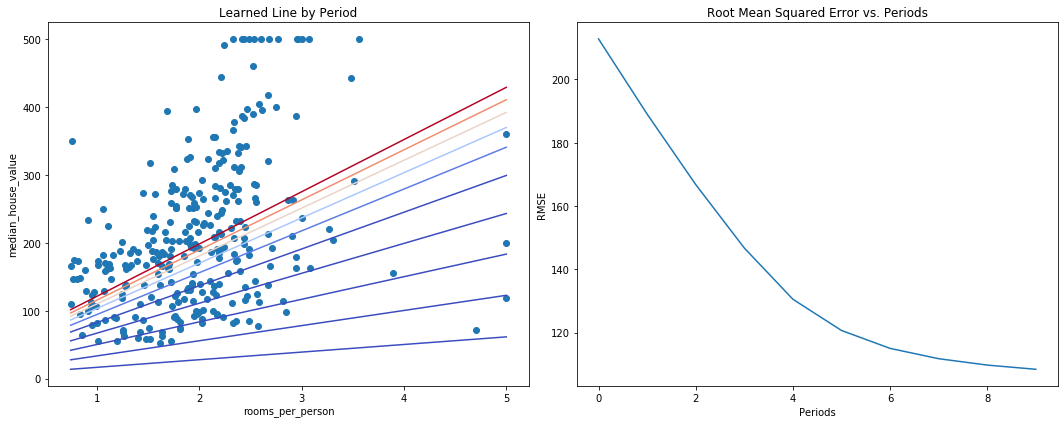

In [29]:
calibration_data = train_model(
    learning_rate = 0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

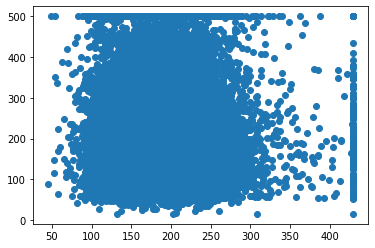

In [30]:
_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])